In [2]:
import numpy as np
import matplotlib.pyplot as plt

loss_limits = (-0.1, 1.3)

title_fontsize = 18
label_fontsize = 18 
tick_fontsize = 15
colorbar_fontsize = 17
legend_fontsize = 16

# Defining the VQE Problem Parameters

In [3]:
from dataclasses import dataclass
from qulacs import Observable

@dataclass
class VQEProblem:
    N_QUBITS: int
    DEPTH: int
    TRANSVERSE_FIELD_COEFFICIENT: float
    parameters: list[float]
    LOSS_HAMILTONIAN: Observable
    LOSS_HAMILTONIAN_SPECTRUM: list[float]

In [4]:
# # Defining VQE parameters

# from openfermion.transforms import get_fermion_operator, jordan_wigner
# from openfermion.linalg import get_sparse_operator
# from openfermion.chem import MolecularData
# from openfermionpyscf import run_pyscf
# from scipy.optimize import minimize
# from pyscf import fci

# basis = "sto-3g"
# multiplicity = 1
# charge = 0
# distance  = 0.977
# geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
# description  = "tmp"
# molecule = MolecularData(geometry, basis, multiplicity, charge, description)
# molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
# n_qubits = molecule.n_qubits
# n_electron = molecule.n_electrons
# fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
# jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

# depth = n_qubits
# param_dim = n_qubits*depth*4
# param_list = np.random.random(param_dim)*1e-1

# from qulacs import Observable
# from qulacs.observable import create_observable_from_openfermion_text
# qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

# # n_qubits = 4
# # depth = n_qubits
# # param_dim = n_qubits*depth*4

# # param_list = np.random.random(param_dim)*1e-1

# Defining the Loss Hamiltonian

In [5]:
# Defining Ising Hamiltonian
from qulacs import Observable
from scipy.sparse.linalg import eigs

def ising_model_H(n_qubits, transverse_field_coefficient):
    """ising_model_H
    Returns Ising model Hamiltonian observable

    Args:
        n_qubits (:class:`int`):
            the number of qubits
        h_parameter (:class:`float`)
            h parameter of Hamiltonian

    Returns:
        :class:`qulacs.Observable`

    """

    ising_hamiltonian = Observable(n_qubits)

    # Building the Transverse field Ising Hamiltonian
    for i in range(n_qubits-1): ising_hamiltonian.add_operator(1.0 ,f"Z {i} Z {i+1}")
    for i in range(n_qubits): ising_hamiltonian.add_operator(transverse_field_coefficient, f"X {i}")

    if n_qubits < 5:

        n_eigenvalues = 2**(n_qubits-1)

    else:
        n_eigenvalues = 30

    energies = np.real(eigs(ising_hamiltonian.get_matrix(), k=n_eigenvalues, which='SR')[0])

    return ising_hamiltonian, energies

# Building the Ansatz Preparation Circuit

In [6]:
from qulacs import ParametricQuantumCircuit
from qulacs.gate import CZ

def perceptron_circuit(n_qubits, depth, param_list):
    """ansatz_circuit
    Returns ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubits.
        depth (:class:`int`):
            depth of the circuit (the number of layers).
        param_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.ParametricQuantumCircuit`
    """

    circuit = ParametricQuantumCircuit(n_qubits)

    gate_offset = 1 * n_qubits # number of parameters per operator times number of operators
    
    for d in range(depth):

        depth_offset = d*gate_offset*4
        # print(depth_offset)

        # print("new layer with depth offset ", depth_offset)

        for i in range(n_qubits):
            theta = param_list[i + gate_offset*0 + depth_offset]
            # print("RX layer ", param_list[i + gate_offset*0 + depth_offset])
            # gate = RX(i, param_list[i + gate_offset*0 + depth_offset])
            circuit.add_parametric_RX_gate(i, theta)

        for i in range(n_qubits):
            theta = param_list[i + gate_offset*1 + depth_offset]
            # print("RZ layer ", param_list[i + gate_offset*1 + depth_offset])
            # gate = RZ(i, param_list[i + gate_offset*1 + depth_offset])
            circuit.add_parametric_RZ_gate(i, theta)


        for i in range(n_qubits-1):
            gate = CZ(i, n_qubits-1)
            circuit.add_gate(gate)

        for i in range(n_qubits):
            theta = param_list[i + gate_offset*2 + depth_offset]
            # print("RX layer ", param_list[i + gate_offset*2 + depth_offset])
            # gate = RX(i, param_list[i + gate_offset*2 + depth_offset])
            circuit.add_parametric_RX_gate(i, theta)

        for i in range(n_qubits):
            theta = param_list[i+ gate_offset*3 + depth_offset]
            # print("RZ layer ", param_list[i + gate_offset*3 + depth_offset])
            # gate = RZ(i, param_list[i+ gate_offset*3 + depth_offset])
            circuit.add_parametric_RZ_gate(i, theta)


    return circuit


# Defining the Loss Function

In [7]:
from qulacs import QuantumState

def loss_function(parameters, vqe):
    state = QuantumState(vqe.N_QUBITS)
    circuit = perceptron_circuit(vqe.N_QUBITS, vqe.DEPTH, parameters)
    circuit.update_quantum_state(state)
    return vqe.LOSS_HAMILTONIAN.get_expectation_value(state)


In [8]:
%%time

loss_function(param_list, vqe_problem)

NameError: name 'param_list' is not defined

# Setting up the Gradient Descent Optimizer

In [9]:
# scipy optimization

from scipy.optimize import minimize

depth = n_qubits
gates_per_layer = n_qubits
param_dim = gates_per_layer*4*depth
param_list = np.random.random(param_dim)*1e-1


cost_history = []
cost_history.append(loss_function(param_list))
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(loss_function, param_list,
               method=method,
               options = options,
               callback=lambda x: cost_history.append(loss_function(x)))

TypeError: loss_function() missing 1 required positional argument: 'vqe'

In [10]:
def calculate_gradient(vqe_problem, param_list):

    circuit = perceptron_circuit(vqe_problem.N_QUBITS, vqe_problem.DEPTH, param_list)

    gradient = np.asarray(circuit.backprop(vqe_problem.LOSS_HAMILTONIAN))

    return gradient


In [11]:
# Gradient descent optimization

def gradient_descent_optimizer(vqe_problem, n_iters, learning_rate):

    cost_history = []
    param_history = []

    param_list = vqe_problem.parameters

    for i in range(n_iters):

        circuit = perceptron_circuit(vqe_problem.N_QUBITS, vqe_problem.DEPTH, param_list)

        gradient = np.asarray(circuit.backprop(vqe_problem.LOSS_HAMILTONIAN))

        param_list = param_list - gradient * learning_rate

        vqe_problem.parameters = param_list
        
        param_history.append(param_list)
        
        cost_history.append(loss_function(param_list, vqe_problem))

    return param_list, cost_history, param_history


# Setting up a VQE Problem

In [12]:
# Defining VQE parameters
N_QUBITS = 8
TRANSVERSE_FIELD_COEFFICIENT = 0.1

DEPTH = N_QUBITS
GATES_PER_LAYER = N_QUBITS
PARAM_DIM = GATES_PER_LAYER*4*DEPTH
param_list = np.random.random(PARAM_DIM)*1e-1

LOSS_HAMILTONIAN, LOSS_HAMILTONIAN_SPECTRUM = ising_model_H(N_QUBITS, TRANSVERSE_FIELD_COEFFICIENT)

vqe_problem = VQEProblem(N_QUBITS, DEPTH, TRANSVERSE_FIELD_COEFFICIENT, param_list, LOSS_HAMILTONIAN, LOSS_HAMILTONIAN_SPECTRUM)

print(vqe_problem.LOSS_HAMILTONIAN_SPECTRUM)


[-7.02501881 -7.0250188  -5.20772966 -5.20772968 -5.15960798 -5.15960796
 -5.0903984  -5.09039842 -5.01256918 -5.01256916 -4.93832726 -4.93832728
 -4.83860107 -4.83860105 -4.87786049 -4.87786047 -3.34231885 -3.34231883
 -3.27310926 -3.27310928 -3.22498757 -3.22498759 -3.19528004 -3.19528002
 -3.14715835 -3.14715833 -3.12103812 -3.12103814 -3.07794876 -3.07794878]


Gradient descent optimization (200 iterations with learning rate of 0.05) :
Found ground state energy: -7.02140578523874
Real ground state energy: -7.025018814833033
Hamiltonian spectrum: [-7.02501881 -7.0250188  -5.20772966 -5.20772968 -5.15960798 -5.15960796
 -5.0903984  -5.09039842 -5.01256918 -5.01256916 -4.93832726 -4.93832728
 -4.83860107 -4.83860105 -4.87786049 -4.87786047 -3.34231885 -3.34231883
 -3.27310926 -3.27310928 -3.22498757 -3.22498759 -3.19528004 -3.19528002
 -3.14715835 -3.14715833 -3.12103812 -3.12103814 -3.07794876 -3.07794878]


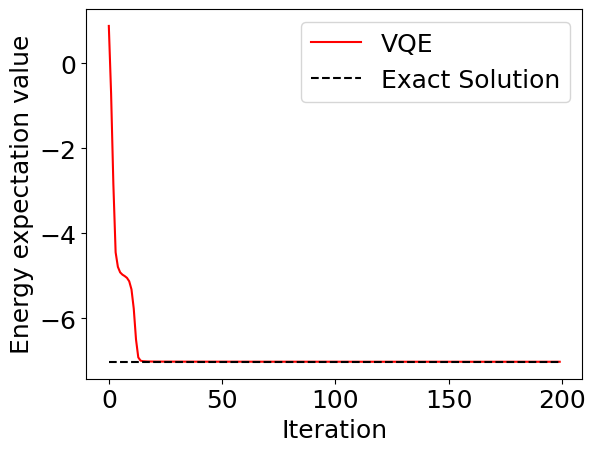

In [13]:
N_ITERS = 200
LEARNING_RATE = 0.05
gs_energy = np.amin(vqe_problem.LOSS_HAMILTONIAN_SPECTRUM)

print(f"Gradient descent optimization ({N_ITERS} iterations with learning rate of {LEARNING_RATE}) :")

final_parameters, cost_history, param_history = gradient_descent_optimizer(vqe_problem, N_ITERS, LEARNING_RATE)

print(f"Found ground state energy: {loss_function(final_parameters, vqe_problem)}")
print(f"Real ground state energy: {gs_energy}")

print(f"Hamiltonian spectrum: {vqe_problem.LOSS_HAMILTONIAN_SPECTRUM}")

plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.plot(range(len(cost_history)), [gs_energy]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

# Setting up/running the VQE simulations for ORQVIZ

In [14]:
def setup_vqe_problem(problem):
    """Defines a new instance of a VQE problem with random parameters
    
    """
    n_qubits = problem["qubits"]
    depth = problem["depth"]
    trials = problem["trials"]
    transverse_field_coefficient = problem["transverse_field_coefficient"]


    gates_per_layer = n_qubits
    param_dim = gates_per_layer*4*depth
    param_list = np.random.random(param_dim)*1e-1*10

    loss_hamiltonian, loss_hamiltonian_spectrum = ising_model_H(n_qubits, transverse_field_coefficient)

    return VQEProblem(n_qubits, depth, transverse_field_coefficient, param_list, loss_hamiltonian, loss_hamiltonian_spectrum)    

In [60]:
%%time


# vqe_problems = [
#   {
#     'qubits': 4,
#     'depth': 4,
#     'transverse_field_coefficient': 0.0,
#     'epochs': 80,
#     'learning_rate': 0.05,
#     'trials': 100,
#   },
#   {
#     'qubits': 6,
#     'depth': 6,
#     'transverse_field_coefficient': 0.0,
#     'epochs': 80,
#     'learning_rate': 0.05,
#     'trials': 100,
#   },
#   {
#     'qubits': 8,
#     'depth': 8,
#     'transverse_field_coefficient': 0.0,
#     'epochs': 80,
#     'learning_rate': 0.05,
#     'trials': 100,
#   },
#   {
#     'qubits': 10,
#     'depth': 10,
#     'transverse_field_coefficient': 0.0,
#     'epochs': 80,
#     'learning_rate': 0.05,
#     'trials': 100,
#   },
#   {
#     'qubits': 4,
#     'depth': 4,
#     'transverse_field_coefficient': 0.1,
#     'epochs': 80,
#     'learning_rate': 0.05,
#     'trials': 100,
#   },
#   {
#     'qubits': 6,
#     'depth': 6,
#     'transverse_field_coefficient': 0.1,
#     'epochs': 80,
#     'learning_rate': 0.05,
#     'trials': 100,
#   },
#   {
#     'qubits': 8,
#     'depth': 8,
#     'transverse_field_coefficient': 0.1,
#     'epochs': 80,
#     'learning_rate': 0.05,
#     'trials': 100,
#   },
#   {
#     'qubits': 10,
#     'depth': 10,
#     'transverse_field_coefficient': 0.1,
#     'epochs': 80,
#     'learning_rate': 0.05,
#     'trials': 100,
#   },
# ]

vqe_problems = [
  {
    'qubits': 6,
    'depth': 6,
    'transverse_field_coefficient': 0.1,
    'epochs': 200,
    'learning_rate': 0.05,
    'trials': 100,
  },
]

for problem in vqe_problems:
    
  print(problem)
  print("##################################################################")
  epochs = problem['epochs']
  trials = problem['trials']
  learning_rate = problem['learning_rate']
  n_qubits = problem['qubits']
  transverse_field_coefficient = problem['transverse_field_coefficient']

  loss_hamiltonian, loss_hamiltonian_spectrum = ising_model_H(n_qubits, transverse_field_coefficient)
  problem['loss_hamiltonian'], problem['loss_hamiltonian_spectrum'] = loss_hamiltonian, loss_hamiltonian_spectrum

  all_parameters_trajectories = []
  all_costs_trajectories = []
  
  for i in range(trials):

    vqe_problem = setup_vqe_problem(problem)

    gs_energy = np.amin(loss_hamiltonian_spectrum)

    print(f"  Gradient descent optimization ({epochs} iterations with learning rate of {learning_rate}) :")

    final_parameters, cost_history, param_history = gradient_descent_optimizer(vqe_problem, epochs, learning_rate)

    all_parameters_trajectories.append(param_history)
    all_costs_trajectories.append(cost_history)

    print(f"  Found ground state energy: {loss_function(final_parameters, vqe_problem)}")
    print(f"  Real ground state energy: {gs_energy}")
    print("##################################################################")


  # sorting the data
  all_parameters_trajectories = np.array(all_parameters_trajectories)
  # all_final_parameters = all_parameter_trajectories[:,-1]
  all_costs_trajectories = np.array(all_costs_trajectories)

  sorted_indices = np.argsort(all_costs_trajectories[:,-1])
  all_parameters_trajectories = all_parameters_trajectories[sorted_indices]
  all_final_parameters = all_parameters_trajectories[:,-1]
  all_costs_trajectories = all_costs_trajectories[sorted_indices]

  problem['simulation_results'] = {
    'all_parameters_trajectories': all_parameters_trajectories,
    'all_costs_trajectories': all_costs_trajectories,
    'all_final_parameters': all_final_parameters
  }



{'qubits': 6, 'depth': 6, 'transverse_field_coefficient': 0.1, 'epochs': 200, 'learning_rate': 0.05, 'trials': 100}
##################################################################
  Gradient descent optimization (200 iterations with learning rate of 0.05) :
  Found ground state energy: -5.015662484509742
  Real ground state energy: -5.020016662087937
##################################################################
  Gradient descent optimization (200 iterations with learning rate of 0.05) :
  Found ground state energy: -5.0149687767990985
  Real ground state energy: -5.020016662087937
##################################################################
  Gradient descent optimization (200 iterations with learning rate of 0.05) :
  Found ground state energy: -5.015457235047289
  Real ground state energy: -5.020016662087937
##################################################################
  Gradient descent optimization (200 iterations with learning rate of 0.05) :
  Found ground sta

## Sanity check

In [61]:
# Sanity check to make sure the parameters match the costs, and they do :)

print(vqe_problems[0]["simulation_results"]["all_costs_trajectories"][3][-1])

loss_parameters = vqe_problems[0]["simulation_results"]["all_parameters_trajectories"][3][-1]

vqe_problem = setup_vqe_problem(vqe_problems[0])

print(loss_function(loss_parameters, vqe_problem))

-5.018303763789343
-5.018303763789343


## Creating the folders to store the figures generated with ORQVIZ

First, we define a function to create a folder at a given path and then we create the folder in which to store the results for the specific loss hamiltonian

In [62]:
from os import mkdir
from os.path import exists


def create_folder(path):

  if not exists(path):
    mkdir(path)

    print("Folder %s created!" % path)
  else:
    print("Folder %s already exists" % path)


In [63]:
GLOBAL_PATH = 'Results/'

hamiltonian_path = '1D Ising Model/'

results_path = GLOBAL_PATH + hamiltonian_path

create_folder(results_path)

Folder Results/1D Ising Model/ already exists


# Visualizing Results with ORQVIZ

### Simple Figures

#### Trainig Progress Plots

In [64]:
def make_training_loss_plot(problem, ax):

    # vqe_problem = setup_vqe_problem(problem)

    simulation_results = problem['simulation_results']
    n_qubits = problem['qubits']
    transverse_field_coefficient = problem['transverse_field_coefficient']
    epochs = problem['epochs']
    trials = problem['trials']
    gs_energy = np.amin(problem['loss_hamiltonian_spectrum'])

    all_costs_trajectories = simulation_results['all_costs_trajectories']

    # fig, ax = plt.subplots()

    ax.plot(all_costs_trajectories.T, linewidth=2.5, color=plt.get_cmap("coolwarm", 7)(0), alpha=0.9)

    ax.set_title(f"Training Progress of {trials} Trials for {n_qubits} Qubits with h = {transverse_field_coefficient}", fontsize=title_fontsize*1, pad=20)
    ax.set_ylabel("Loss", fontsize=label_fontsize)
    ax.set_xlabel("Training Iterations", fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    # plt.ylim(loss_limits)
    ax.plot(range(len(all_costs_trajectories[0])), [gs_energy]*len(all_costs_trajectories[0]), linestyle="dashed", color="black", label="Exact Solution")
    ax.scatter([epochs, epochs, epochs], all_costs_trajectories[[0, 1, -1],-1], color=plt.get_cmap("coolwarm", 7)(6), linewidth=2, zorder=3)
    # plt.annotate("gr", xy=(epochs-10,0))

    ax.legend()

    # return ax

Folder Results/1D Ising Model/6 qubits/ already exists


CPU times: user 1.01 s, sys: 72.5 ms, total: 1.08 s
Wall time: 255 ms


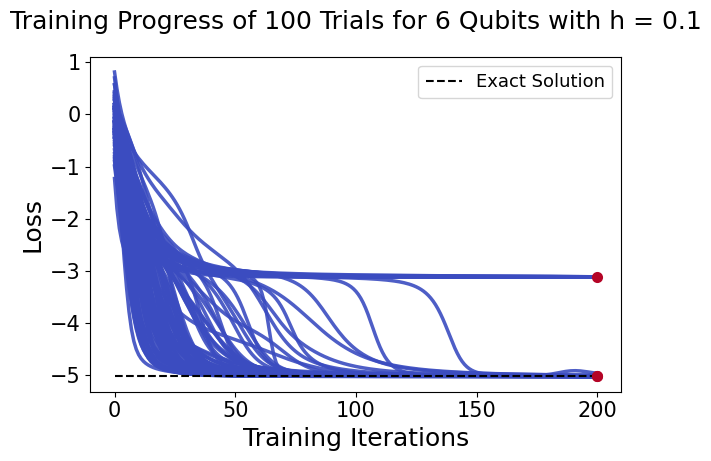

In [65]:
%%time

for problem in vqe_problems:

    n_qubits = problem['qubits']
    depth = problem['depth']
    transverse_field_coefficient = problem['transverse_field_coefficient']

    qubits_folder = results_path + f'{n_qubits} qubits/'

    create_folder(qubits_folder)

    filename = qubits_folder + f'training_progress_{n_qubits}qubits_{depth}depth_{transverse_field_coefficient}transverse_field.pdf'

    fig, ax = plt.subplots()

    make_training_loss_plot(problem, ax)

    plt.tight_layout()

    plt.savefig(filename, bbox_inches="tight")
    # plt.show()


In [66]:
# %%time
# # Making the training losses plots for each experiment

# for problem in vqe_problems:
    
#     training_loss_figure, training_loss_axes = make_training_loss_plot(problem)
#     problem['figures'] = {
#         'training_progress': [training_loss_figure, training_loss_axes]
#     }

#### Final Losses Histograms

In [83]:
# problem = vqe_problems[0]

def make_final_losses_histogram(problem, ax, show_spectrum = False):

    simulation_results = problem["simulation_results"]
    n_qubits = problem["qubits"]
    transverse_field_coefficient = problem["transverse_field_coefficient"]
    # epochs = problem["epochs"]
    trials = problem["trials"]
    loss_hamiltonian_spectrum = problem["loss_hamiltonian_spectrum"]

    all_costs_trajectories = simulation_results["all_costs_trajectories"]

    # fig, ax = plt.subplots()

    ax.hist(all_costs_trajectories[:,-1], bins=100, width=0.1, align="mid", color='tomato', alpha=0.9)
    ax.set_title(f"Histogram for {trials} final losses with h = {transverse_field_coefficient}\n({n_qubits}-qubit Digital VQE)", fontsize=title_fontsize, pad=20)
    ax.set_xlabel("Loss", fontsize=label_fontsize)
    ax.set_ylabel("Occurence", fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_fontsize)


    if show_spectrum:
        spectrum_lines = np.unique(loss_hamiltonian_spectrum)
        for state in range(len(spectrum_lines)):

            line = spectrum_lines[state]

            if state == 0:
                # label = 'Ground State'
                label = 'Hamiltonian Spectrum'
            else:
                # label = f"{state} Excited State"
                label = ''

            ax.axvline(x = line, color = 'black', label = label, linestyle = ':', linewidth=1)

    # ax.set_xlim(loss_limits)

    ax.legend(loc='upper right')

    # return ax



In [84]:
# problem = vqe_problems[1]

# n_qubits = problem['qubits']
# depth = problem['depth']
# transverse_field_coefficient = problem['transverse_field_coefficient']

# fig, ax = plt.subplots()

# make_final_losses_histogram(problem, ax, True)

# plt.tight_layout()

Folder Results/1D Ising Model/6 qubits/ already exists
CPU times: user 406 ms, sys: 7.64 ms, total: 413 ms
Wall time: 176 ms


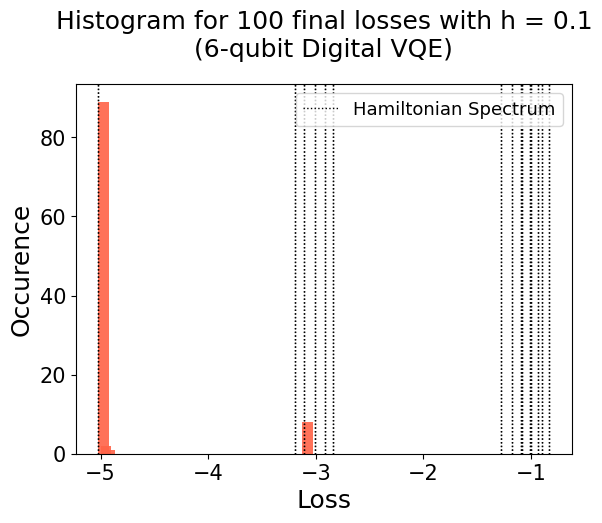

In [87]:
%%time

for problem in vqe_problems:

    n_qubits = problem['qubits']
    depth = problem['depth']
    transverse_field_coefficient = problem['transverse_field_coefficient']

    qubits_folder = results_path + f'{n_qubits} qubits/'

    create_folder(qubits_folder)

    filename = qubits_folder + f'final_losses_histograms_{n_qubits}qubits_{depth}depth_{transverse_field_coefficient}transverse_field.pdf'

    fig, ax = plt.subplots()

    make_final_losses_histogram(problem, ax, True)

    # plt.tight_layout()

    plt.savefig(filename, bbox_inches="tight")
    # plt.show()


In [70]:
# %%time

# for problem in vqe_problems:

#     final_losses_histogram_figure, final_losses_histogram_axes = make_final_losses_histogram(problem)
#     problem["figures"]['final_losses_histogram'] = [final_losses_histogram_figure, final_losses_histogram_axes]

#### PCA Plots

In [73]:
from orqviz.pca import get_pca, perform_2D_pca_scan, plot_pca_landscape, plot_scatter_points_on_pca
from orqviz.plot_utils import normalize_color_and_colorbar, get_colorbar_from_ax
from orqviz.loss_function import LossFunctionWrapper

def make_pca_plot(problem, ax, components = (0,1)):

    n_qubits = problem['qubits']
    # trials = problem['trials']
    transverse_field_coefficient = problem['transverse_field_coefficient']

    # Using ORQVIZ loss function wrapper
    orqviz_loss_function = LossFunctionWrapper(loss_function, setup_vqe_problem(problem))

    simulation_results = problem['simulation_results']

    all_parameters_trajectories = simulation_results['all_parameters_trajectories']
    all_final_parameters = simulation_results['all_final_parameters']

    # fig, ax = plt.subplots(figsize=(5*1.5 ,5))

    whiches = np.append(np.arange(0,8), np.arange(-8,-1), axis=0)
    # new list of indeces so that each time they are chosen randomly
    # whiches = np.random.choice(len(all_parameters_trajectories), size=20, replace=False)

    pca = get_pca(np.concatenate([all_parameters_trajectories[which] for which in whiches], axis=0), components_ids = components)

    scanpca_result = perform_2D_pca_scan(pca, orqviz_loss_function, n_steps_x=100, offset=3)

    plot_pca_landscape(scanpca_result, pca)

    for which in whiches:
        plot_scatter_points_on_pca(all_parameters_trajectories[which], pca, color="ivory", alpha=0.5)
        plot_scatter_points_on_pca([all_final_parameters[which]], pca, color="red", alpha=1., s=150)

    # normalize_color_and_colorbar(fig, ax, 0., 1.3)

    ax.tick_params(labelsize=tick_fontsize)
    cbar = get_colorbar_from_ax(ax)

    cbar.ax.tick_params(labelsize=label_fontsize)

    ax.set_title(f"PCA on 15 trajectories for {n_qubits} Qubits with h = {transverse_field_coefficient}", fontsize=title_fontsize, pad=20)

    # return fig, ax, pca



Folder Results/1D Ising Model/6 qubits/ already exists
CPU times: user 19.9 s, sys: 4.12 s, total: 24 s
Wall time: 4.82 s


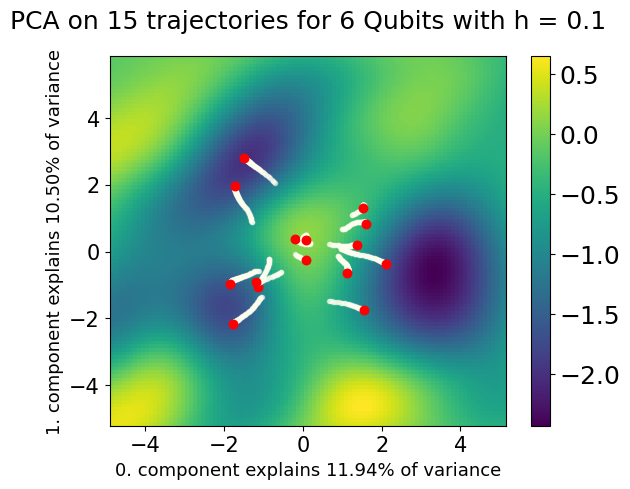

In [74]:
%%time

plt.rcParams['font.size'] = 13

for problem in vqe_problems:

    n_qubits = problem['qubits']
    depth = problem['depth']
    transverse_field_coefficient = problem['transverse_field_coefficient']

    qubits_folder = results_path + f'{n_qubits} qubits/'

    create_folder(qubits_folder)

    filename = qubits_folder + f'pca_plot_{n_qubits}qubits_{depth}depth_{transverse_field_coefficient}transverse_field.pdf'

    fig, ax = plt.subplots()


    make_pca_plot(problem, ax)

    plt.savefig(filename, bbox_inches="tight")
    # plt.show()


In [ ]:
# %%time

# for problem in vqe_problems:

#     pca_plot_figure, pca_plot_axes, pca = make_pca_plot(problem)

#     problem["figures"]['pca_plots'] = [pca_plot_figure, pca_plot_axes, pca]
    

### Mosaics

In [ ]:
MOSAIC = """
        AB
        CC
        CC
        """

for problem in vqe_problems:

        n_qubits = problem['qubits']
        depth = problem['depth']
        transverse_field_coefficient = problem['transverse_field_coefficient']
        trials = problem['trials']

        qubits_folder = results_path + f'{n_qubits} qubits/'

        create_folder(qubits_folder)

        filename = qubits_folder + f'mosaic_plots_{n_qubits}qubits_{depth}depth_{transverse_field_coefficient}transverse_field.pdf'


        fig, ax_dict = plt.subplot_mosaic(MOSAIC, figsize=(11,11))

        # fig.figsize(10,10)

        fig.tight_layout(pad=5.0)

        training_progress_ax = ax_dict['A']
        losses_histogram_ax = ax_dict['B']
        pca_ax = ax_dict['C']


        make_training_loss_plot(problem, training_progress_ax)
        make_final_losses_histogram(problem, losses_histogram_ax, True)
        make_pca_plot(problem, pca_ax)


        training_progress_ax.set_title(f"Training Progress of {trials} Repetitions", fontsize=title_fontsize, pad = 20)
        losses_histogram_ax .set_title(f"Histogram of {trials} Final Losses", fontsize=title_fontsize, pad = 20)
        pca_ax.set_title("PCA of 15 Trajectories", fontsize=title_fontsize, pad = 20)

        fig.suptitle(f"Digital {n_qubits} Qubit VQE with h = {transverse_field_coefficient}", fontsize=title_fontsize*1.1)
        
        plt.subplots_adjust(top=0.9)

        plt.savefig(filename, bbox_inches="tight")

        # plt.show()


## Characterizing the Minima

### Gradients

Before finding the Hessians, let's take a look at the gradients the optimizer converged to. They should all be close to 0, so it is important to get rid of outlier points which do not have a vanishing gradient

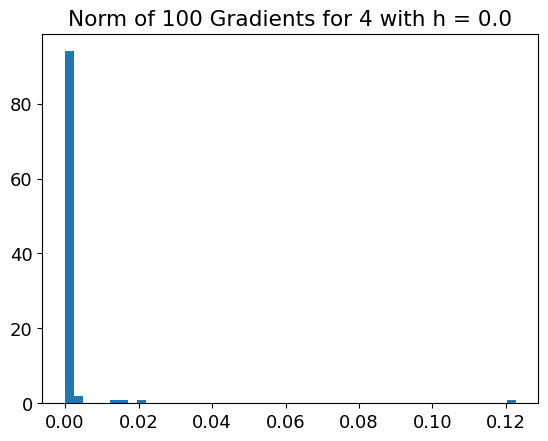

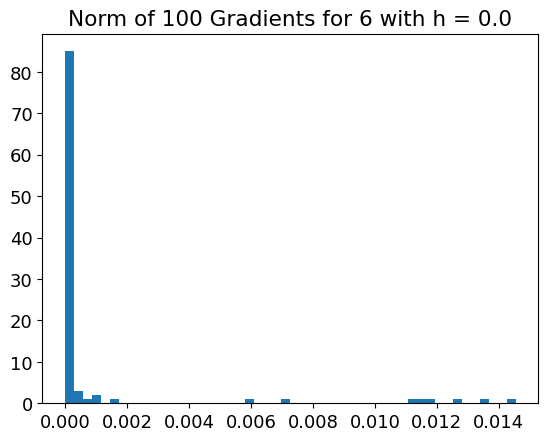

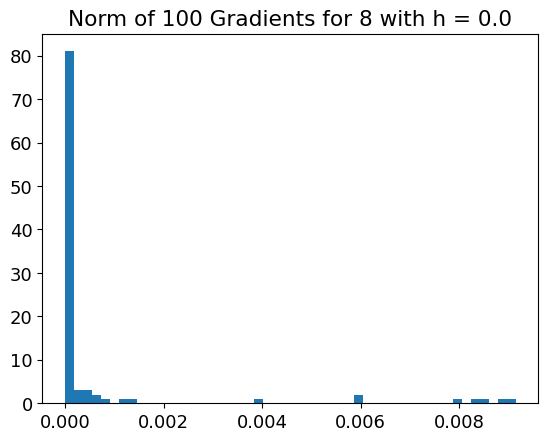

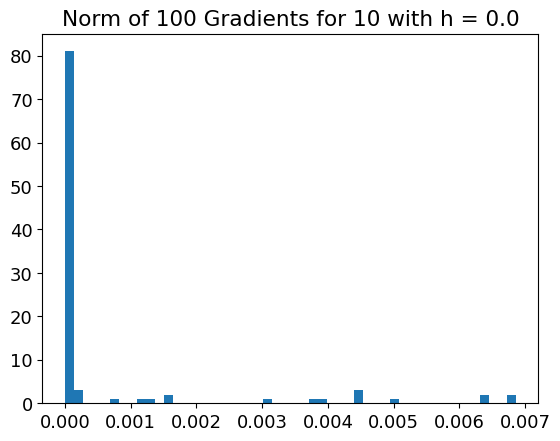

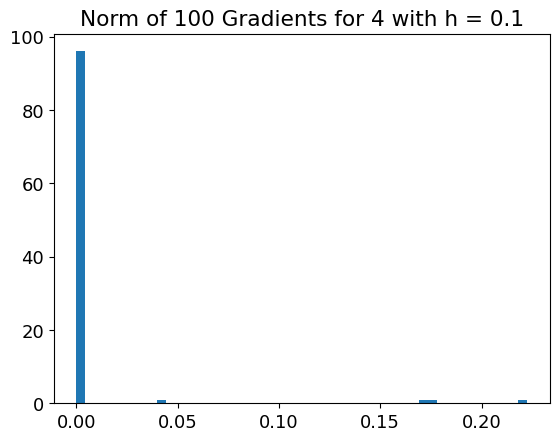

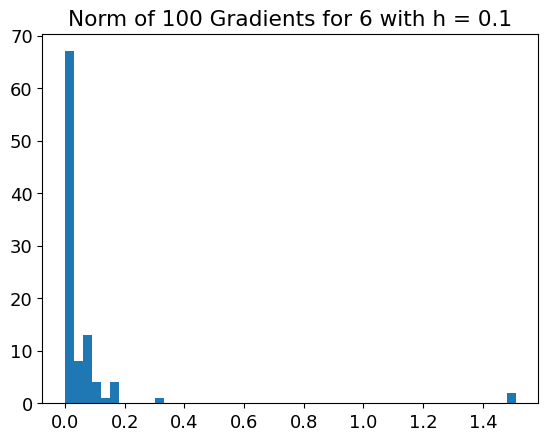

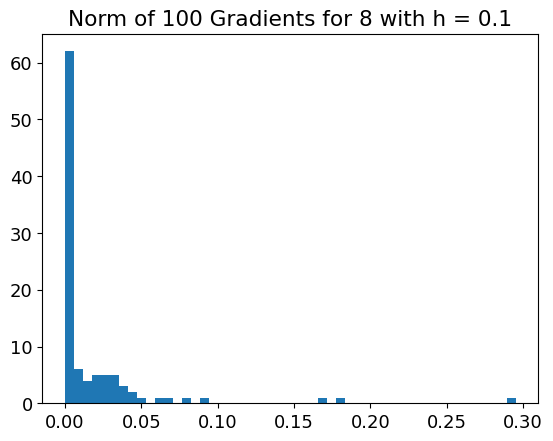

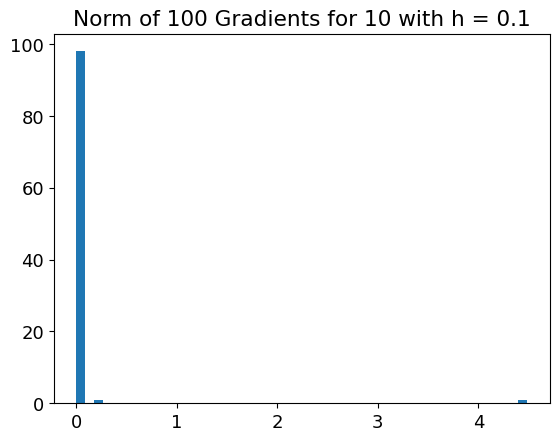

In [40]:
def calculate_gradients(problem):

    simulation_results = problem['simulation_results']

    all_final_parameters = simulation_results['all_final_parameters']

    vqe_problem = setup_vqe_problem(problem)

    all_final_gradients = []
    critical_points = []

    for param_list in all_final_parameters:
        gradient = calculate_gradient(vqe_problem, param_list)
        all_final_gradients.append(gradient)
        # print(gradient)

    return np.asarray(all_final_gradients)


# problem = vqe_problems[-1]

for problem in vqe_problems:

    all_final_gradients = calculate_gradients(problem)
    n_qubits = problem['qubits']
    transverse_field_coefficient = problem['transverse_field_coefficient']
    trials = problem['trials']

    gradient_norms = np.linalg.norm(all_final_gradients, axis = 1)

    # print(gradient_norms)
    plt.title(f'Norm of {trials} Gradients for {n_qubits} with h = {transverse_field_coefficient}')
    plt.hist(gradient_norms, bins=50, )
    # plt.xscale('log')
    plt.show()



### Hessians

In [15]:
from orqviz.hessians import get_Hessian, perform_1D_hessian_eigenvector_scan, plot_1D_hessian_eigenvector_scan_result
from orqviz.loss_function import LossFunctionWrapper

In [16]:
%%time

# Calculating the Hessians at each final point

for problem in vqe_problems:

    orqviz_loss_function = LossFunctionWrapper(loss_function, setup_vqe_problem(problem))

    simulation_results = problem['simulation_results']

    all_final_parameters = simulation_results['all_final_parameters']

    all_final_hessians = []
    all_final_hessian_determinants = []

    print(f"Estimating Hessians for {problem['qubits']} qubits with h = {problem['transverse_field_coefficient']}")

    count = 0
    for final_param_vector in all_final_parameters:

        hessian = get_Hessian(final_param_vector, orqviz_loss_function, eps=1e-3)

        hessian_determinant = np.linalg.det(hessian.hessian_matrix)

        all_final_hessians.append(hessian)
        all_final_hessian_determinants.append(hessian_determinant)

        count += 1

        print(count)

    
    simulation_results['all_final_hessians'] = np.asarray(all_final_hessians)
    simulation_results['all_final_hessian_determinants'] = np.asarray(all_final_hessian_determinants)

    print('#######################################################################')


Estimating Hessians for 4 qubits with h = 0.0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
#######################################################################
Estimating Hessians for 6 qubits with h = 0.0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
#######################################################################
Estimating Hessians for 8 qubits with h = 0.0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48

#### Inspecting the Determinants

In [ ]:
# Inspecting the determinants of the Hessians

# problem = vqe_problems[0]

for problem in vqe_problems:

    n_qubits = problem['qubits']
    transverse_field_coefficient = problem['transverse_field_coefficient']

    determinants = problem['simulation_results']['all_final_hessian_determinants']

    title = f'Log base 10 of absolute values of Hessians for {n_qubits} with h = {transverse_field_coefficient}'

    # plt.title(title)
    # plt.hist(np.log(np.abs(determinants))*1, bins=100, )
    # # plt.xscale('log')
    # plt.show()

    print(title)
    print(np.sort((np.abs(determinants))))


# print(np.sort(np.log(np.abs(determinants))))

# for determinant in problem['simulation_results']['all_final_hessian_determinants']:
#     print(determinant)

In [ ]:
# Inspecting the determinants of the Hessians

# problem = vqe_problems[0]

for problem in vqe_problems:

    n_qubits = problem['qubits']
    transverse_field_coefficient = problem['transverse_field_coefficient']

    determinants = problem['simulation_results']['all_final_hessian_determinants']

    title = f'Log base 10 of absolute values of Hessians for {n_qubits} with h = {transverse_field_coefficient}'

    plt.title(title)

    histogram_array = np.nan_to_num(np.log(np.abs(determinants)), copy=True, posinf=None, neginf=None)

    plt.hist(histogram_array, bins=100, )
    # plt.xscale('log')
    plt.show()

    # print(title)
    # print(np.sort((np.abs(determinants))))



#### Inspecting the eigenvalues

In [17]:
# inspecting the eigenvalues
# problem = vqe_problems[-1]

for problem in vqe_problems:

    np.set_printoptions(linewidth=np.inf)

    n_qubits = problem['qubits']

    transverse_field_coefficient = problem['transverse_field_coefficient']

    print(f'{n_qubits} Qubits with h = {transverse_field_coefficient}')

    simulation_results = problem['simulation_results']

    gs_energy = problem['loss_hamiltonian_spectrum'][0]

    hessians = simulation_results['all_final_hessians']
    hessian_determinants = simulation_results['all_final_hessian_determinants']

    all_final_costs = simulation_results['all_costs_trajectories'][:,-1]

    eigvals_ratio = []
    eigvals_min = []
    eigvals_max = []


    for trial_count in range(len(all_final_costs)):

        hessian = hessians[trial_count]
        determinant = hessian_determinants[trial_count]
        final_loss = all_final_costs[trial_count]

        eigenvalues = hessian.eigenvalues
        min_eigval = np.min(eigenvalues)
        max_eigval = np.max(eigenvalues)
        ratio = min_eigval/max_eigval

        print(f'Final loss: {final_loss} | True ground state: {gs_energy}')
        print(f'Hessian information: ')
        print(f'        Eigenvalue ratio: {ratio} | Minimum eigenvalue: {min_eigval} | Maximum eigenvalue: {max_eigval}')
        print(f'        Determinant: {determinant}')
        print(f'        Parameter vector: {hessian.params}\n')

        eigvals_ratio.append(ratio)
        eigvals_min.append(min_eigval)
        eigvals_max.append(max_eigval)

        trial_count += 1

    eigvals_ratio = np.asarray(eigvals_ratio)
    eigvals_min = np.asarray(eigvals_min)
    eigvals_max = np.asarray(eigvals_max)


    simulation_results['hessian_min_eigenvalues'] = eigvals_min
    simulation_results['hessian_max_eigenvalues'] = eigvals_max
    simulation_results['hessian_eigenvalues_ratio'] = eigvals_ratio


4 Qubits with h = 0.0
Final loss: -3.000000000000004 | True ground state: -3.0000000000000018
Hessian information: 
        Eigenvalue ratio: -2.737483985919769e-10 | Minimum eigenvalue: -4.109159187582548e-09 | Maximum eigenvalue: 15.010714980317626
        Determinant: 2.3680563632217805e-36
        Parameter vector: [ 0.78504474 -0.30391568  0.39328803  0.58158775  0.95472185  0.63532847  0.13940159 -0.09199311  0.14013445  0.01080186  0.15249237  0.96255675  0.94765201  0.95070108  0.35691743  0.38720819  0.63020499  0.43189493  0.77329214  0.31268876  0.31791815 -0.07862105  0.60214802 -0.2360693   1.01985982  0.5620957   0.83137675  0.99943335  0.83972522 -0.04247348  0.76674202  0.79529456  0.90763567  0.32022689  0.06782998 -0.02316315  0.89937624  0.3356595   0.69287774  0.27815901  0.62551128  0.67261995  0.64947046  0.21237544  0.91452162 -0.16111227  0.71304725  0.52440986  0.61562635  0.71445442  0.68293558 -0.09685777  0.76770416  0.42116632  0.12876767  0.85076578  0.249

In [19]:
def make_minmax_eigval_plot(problem, ax):
    
    simulation_results = problem['simulation_results']
    n_qubits = problem['qubits']
    transverse_field_coefficient = problem['transverse_field_coefficient']
    epochs = problem['epochs']
    trials = problem['trials']
    gs_energy = np.amin(problem['loss_hamiltonian_spectrum'])

    all_costs_trajectories = simulation_results['all_costs_trajectories']

    # fig, ax = plt.subplots()

    eigvals_min = simulation_results['hessian_min_eigenvalues']
    eigvals_max = simulation_results['hessian_max_eigenvalues']
    trial_marks = [i+1 for i in range(len(eigvals_min))]

    ax.set_title(f"Hessian eigenvalues of {trials} trials for {n_qubits} Qubits with h = {transverse_field_coefficient}", fontsize=title_fontsize*1, pad=20)
    ax.set_ylabel("Eigenvalues", fontsize=label_fontsize)
    ax.set_xlabel("Trial", fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    # plt.ylim(loss_limits)
    # ax.plot(range(len(all_costs_trajectories[0])), [gs_energy]*len(all_costs_trajectories[0]), linestyle="dashed", color="black", label="Exact Solution")
    # ax.scatter(trial_marks, eigvals_min, color=plt.get_cmap("coolwarm", 7)(6), linewidth=2, zorder=3)
    # ax.scatter(trial_marks, eigvals_max, color=plt.get_cmap("coolwarm", 7)(6), linewidth=2, zorder=3)

    ax.scatter(trial_marks, eigvals_min, label = 'minimum eigenvalues')
    ax.scatter(trial_marks, eigvals_max, label = 'maximum eigenvalues')

    # plt.annotate("gr", xy=(epochs-10,0))

    ax.legend()




Folder Results/1D Ising Model/4 qubits/ already exists
Folder Results/1D Ising Model/6 qubits/ already exists


/Users/jorgegarciaponce/Research/Yelin/Perceptron/CumulantNODEs/perceptron_venv/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/jorgegarciaponce/Research/Yelin/Perceptron/CumulantNODEs/perceptron_venv/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Folder Results/1D Ising Model/8 qubits/ already exists
Folder Results/1D Ising Model/10 qubits/ already exists
Folder Results/1D Ising Model/4 qubits/ already exists
Folder Results/1D Ising Model/6 qubits/ already exists
Folder Results/1D Ising Model/8 qubits/ already exists
Folder Results/1D Ising Model/10 qubits/ already exists
CPU times: user 2.86 s, sys: 78.5 ms, total: 2.94 s
Wall time: 1.03 s


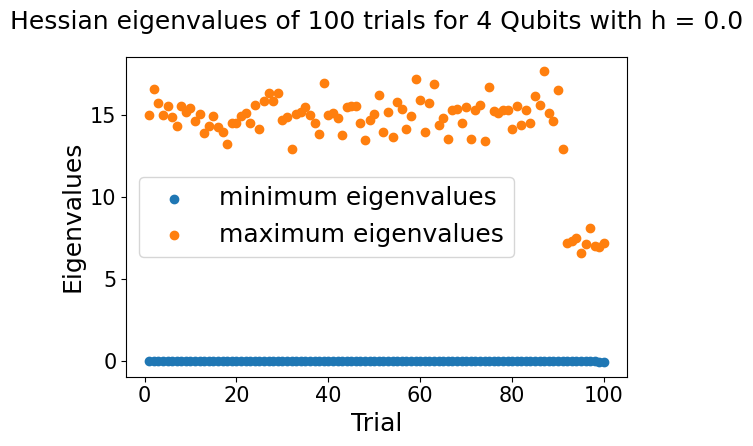

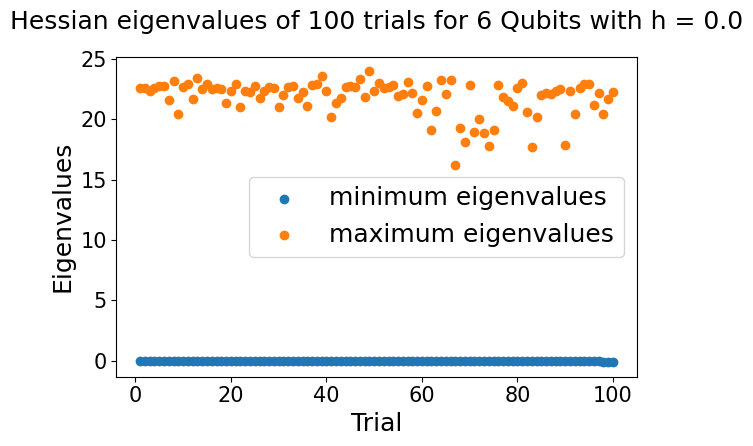

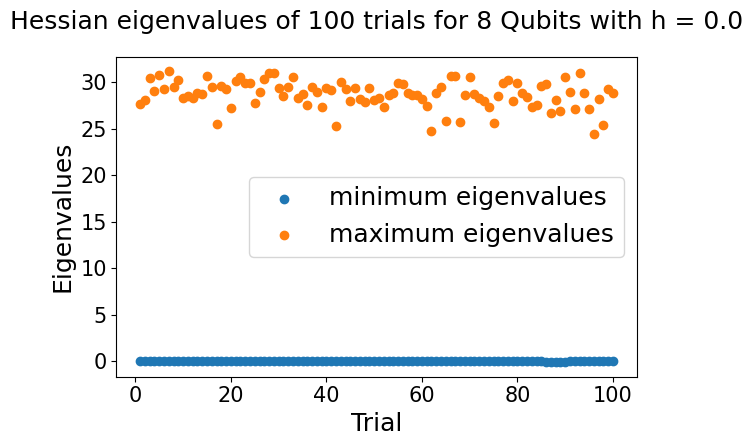

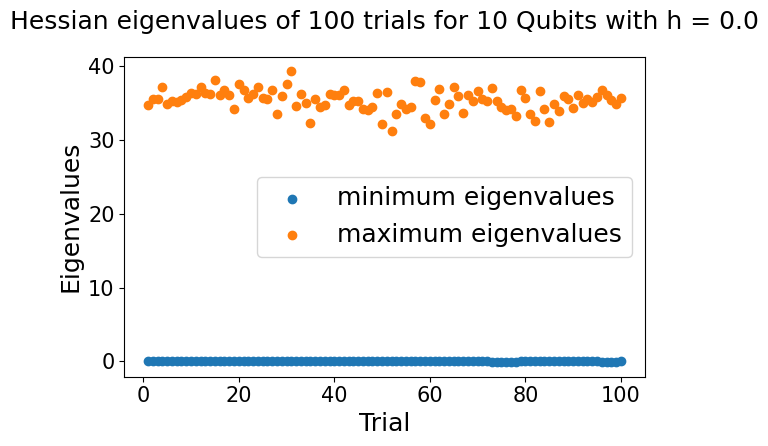

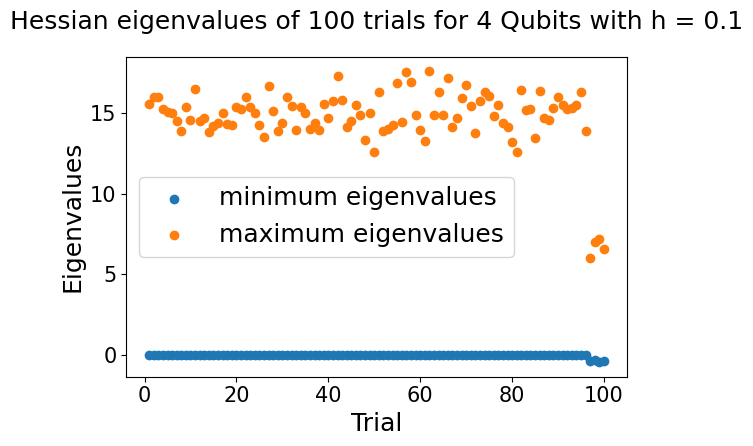

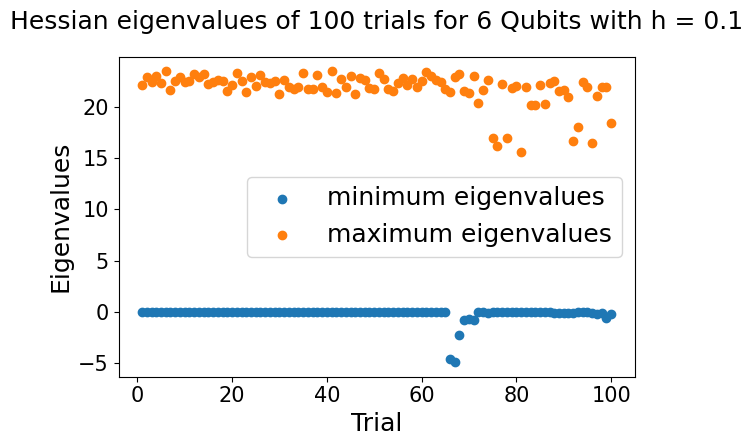

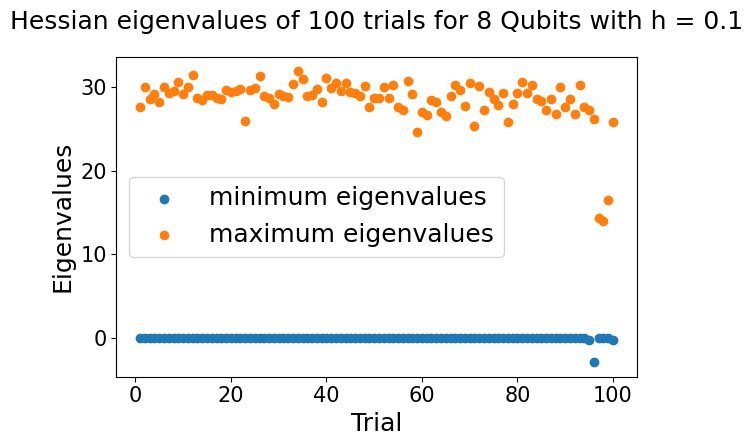

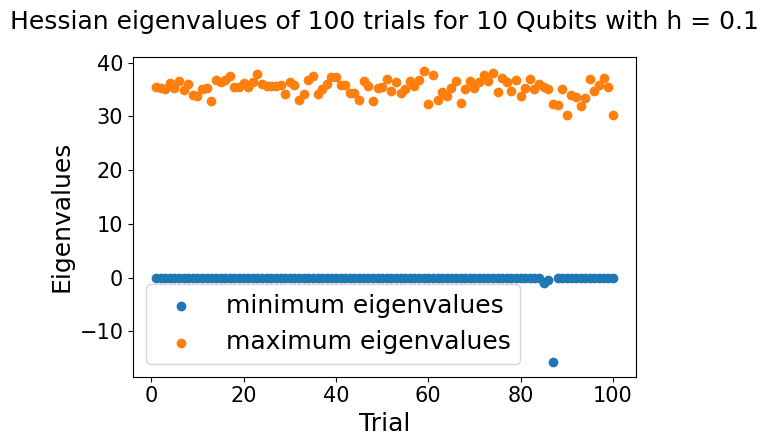

In [20]:
%%time

for problem in vqe_problems:

    n_qubits = problem['qubits']
    depth = problem['depth']
    transverse_field_coefficient = problem['transverse_field_coefficient']

    qubits_folder = results_path + f'{n_qubits} qubits/'

    create_folder(qubits_folder)

    filename = qubits_folder + f'minmax_hessian_eigenvalues_{n_qubits}qubits_{depth}depth_{transverse_field_coefficient}transverse_field.pdf'

    fig, ax = plt.subplots()

    make_minmax_eigval_plot(problem, ax)

    plt.tight_layout()

    plt.savefig(filename, bbox_inches="tight")
    # plt.show()


##### Eigenvalues/Final Losses Mosaics

Folder Results/1D Ising Model/4 qubits/ already exists
Folder Results/1D Ising Model/6 qubits/ already exists


/Users/jorgegarciaponce/Research/Yelin/Perceptron/CumulantNODEs/perceptron_venv/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Folder Results/1D Ising Model/8 qubits/ already exists
Folder Results/1D Ising Model/10 qubits/ already exists
Folder Results/1D Ising Model/4 qubits/ already exists
Folder Results/1D Ising Model/6 qubits/ already exists
Folder Results/1D Ising Model/8 qubits/ already exists
Folder Results/1D Ising Model/10 qubits/ already exists
CPU times: user 5.93 s, sys: 109 ms, total: 6.04 s
Wall time: 2.07 s


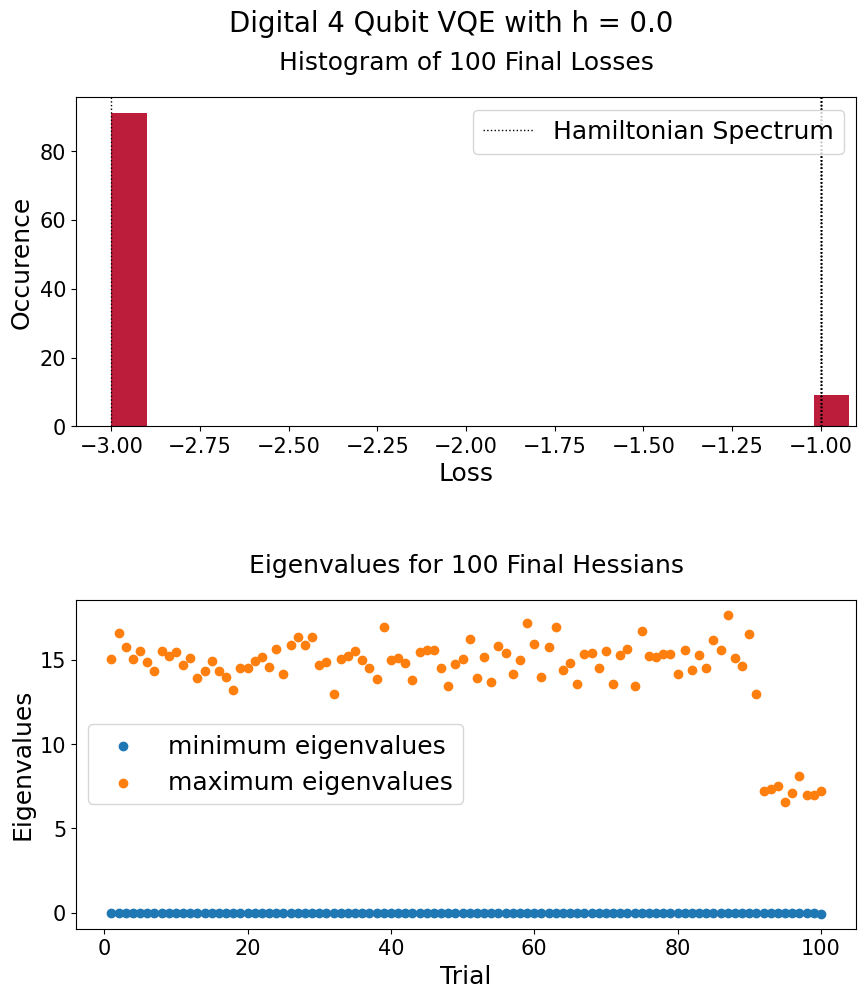

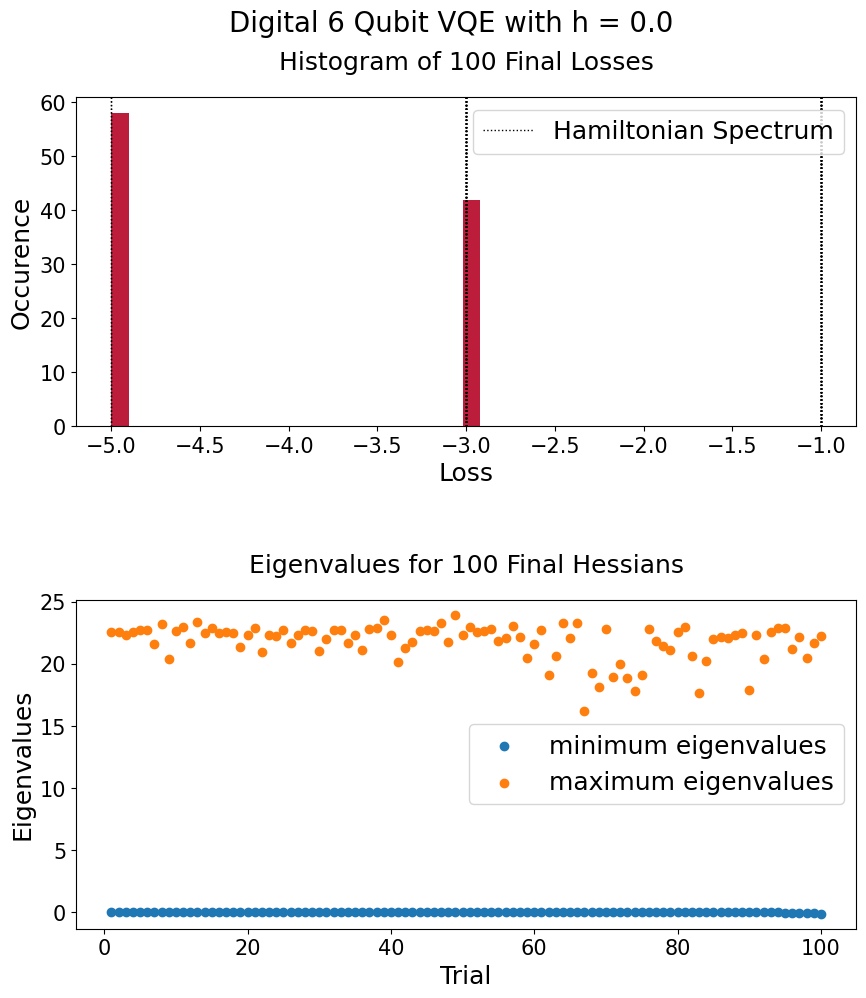

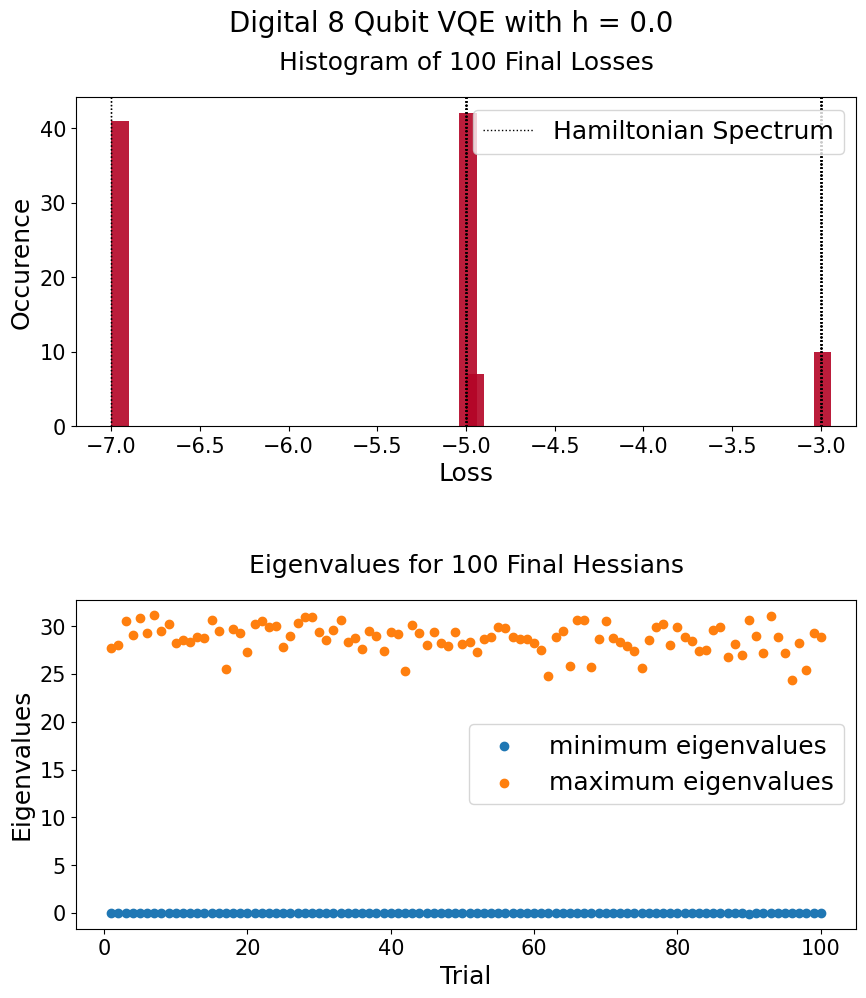

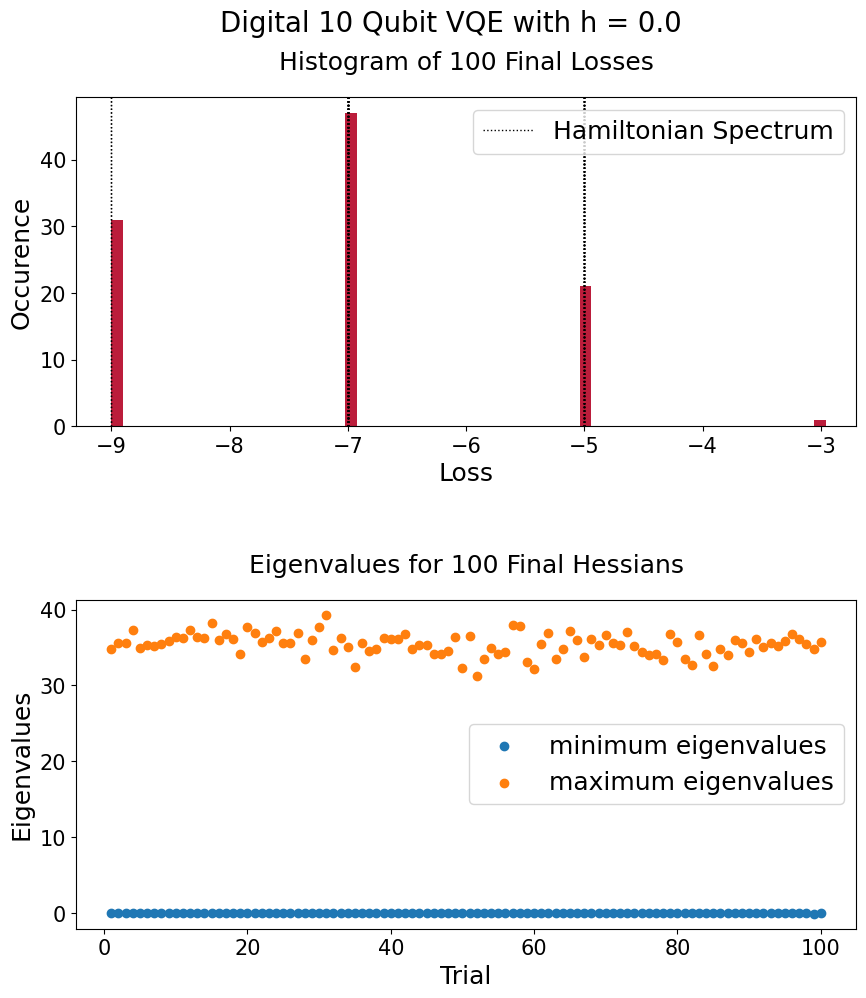

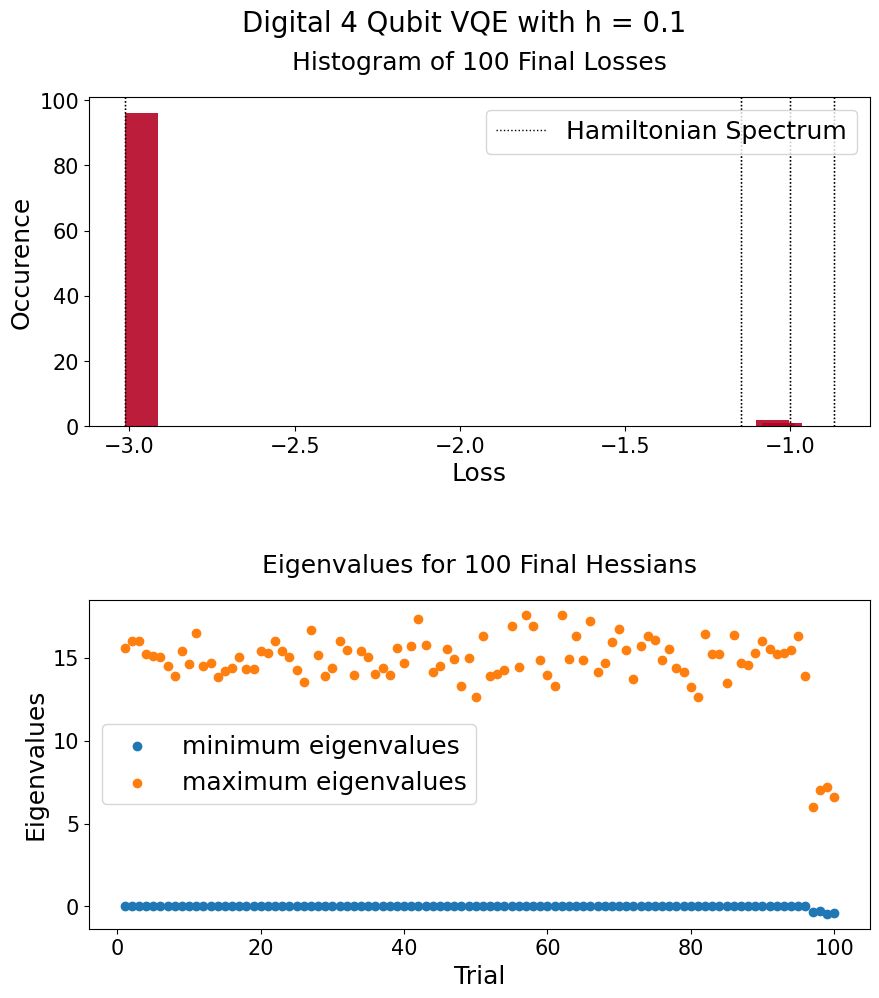

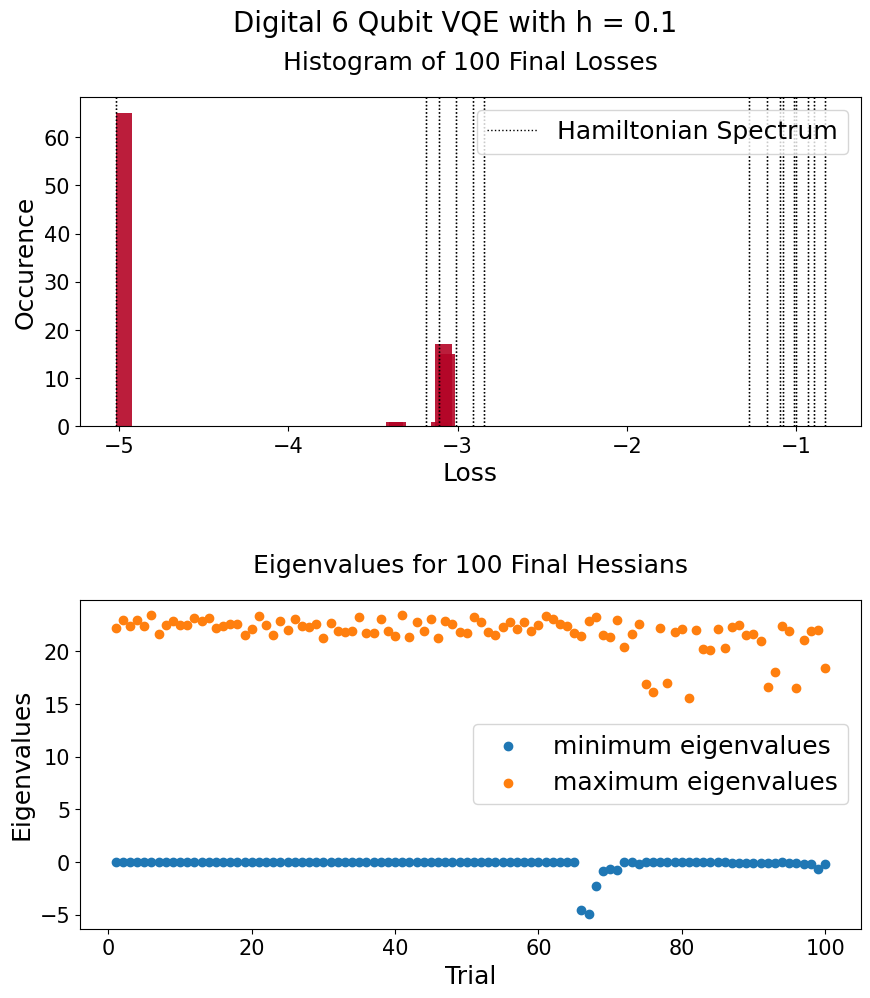

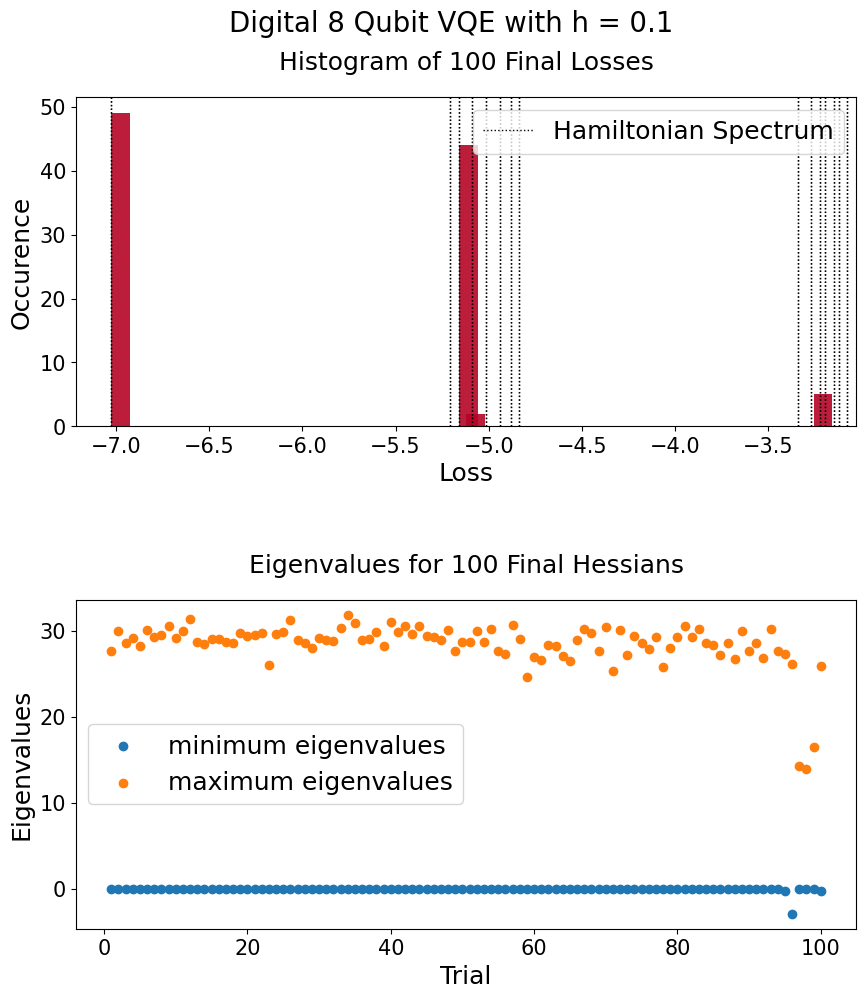

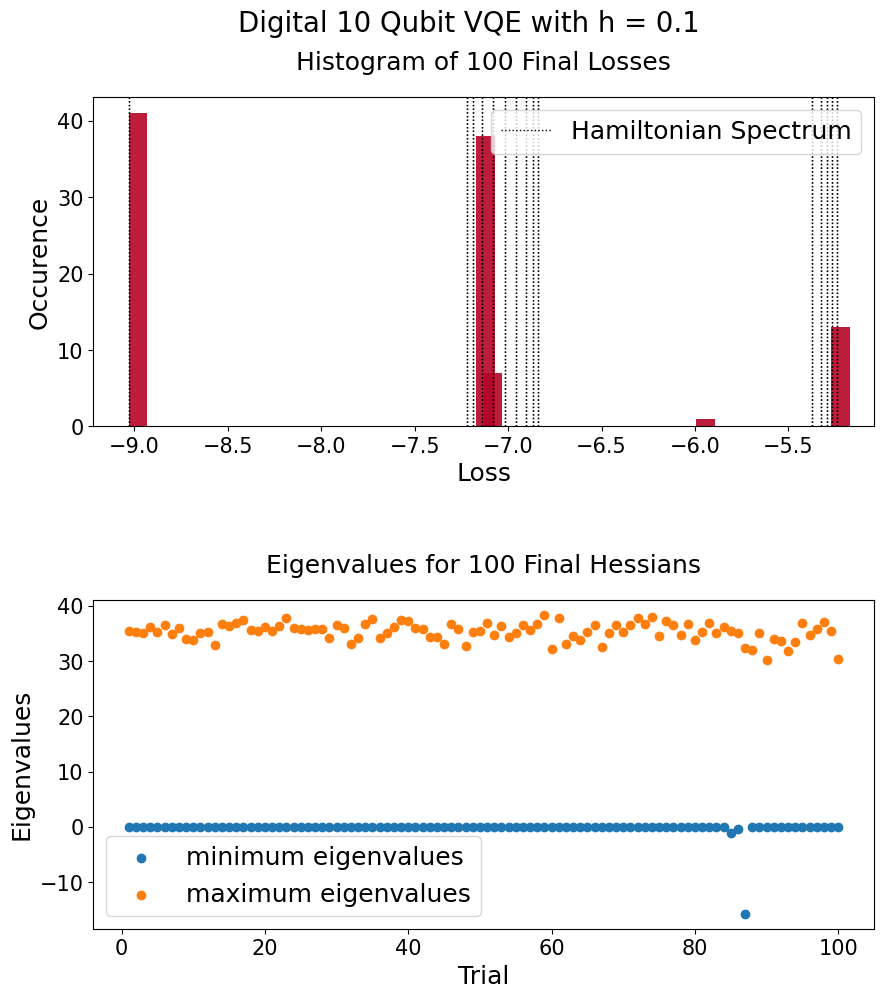

In [23]:
%%time

MOSAIC = """
        AA
        AA
        BB
        BB
        """

for problem in vqe_problems:

    n_qubits = problem['qubits']
    depth = problem['depth']
    trials = problem['trials']
    transverse_field_coefficient = problem['transverse_field_coefficient']

    qubits_folder = results_path + f'{n_qubits} qubits/'

    create_folder(qubits_folder)

    filename = qubits_folder + f'mosaic_eigenvalues_losses_{n_qubits}qubits_{depth}depth_{transverse_field_coefficient}transverse_field.pdf'

    fig, ax_dict = plt.subplot_mosaic(MOSAIC, figsize=(11,11))
    
    fig.tight_layout(pad=5.0)

    losses_histogram_ax = ax_dict['A']
    eigenvalues_ax = ax_dict['B']

    make_minmax_eigval_plot(problem, eigenvalues_ax)
    make_final_losses_histogram(problem, losses_histogram_ax, True)

    losses_histogram_ax.set_title(f"Histogram of {trials} Final Losses", fontsize=title_fontsize, pad = 20)
    eigenvalues_ax.set_title(f"Eigenvalues for {trials} Final Hessians", fontsize=title_fontsize, pad = 20)

    fig.suptitle(f"Digital {n_qubits} Qubit VQE with h = {transverse_field_coefficient}", fontsize=title_fontsize*1.1)

    plt.subplots_adjust(top=0.9)

    # plt.tight_layout()

    plt.savefig(filename, bbox_inches="tight")
    # plt.show()


/Users/jorgegarciaponce/Research/Yelin/Perceptron/CumulantNODEs/perceptron_venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


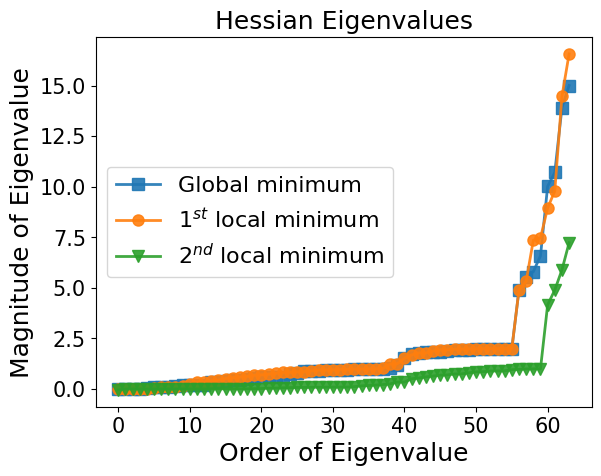

In [25]:
problem = vqe_problems[0]

n_qubits = problem['qubits']
# trials = problem['trials']
transverse_field_coefficient = problem['transverse_field_coefficient']

# Using ORQVIZ loss function wrapper
orqviz_loss_function = LossFunctionWrapper(loss_function, setup_vqe_problem(problem))

simulation_results = problem['simulation_results']

all_parameters_trajectories = simulation_results['all_parameters_trajectories']
all_final_parameters = simulation_results['all_final_parameters']



hessian0 = get_Hessian(all_final_parameters[0], orqviz_loss_function, eps=1e-3)
hessian1 = get_Hessian(all_final_parameters[1], orqviz_loss_function, eps=1e-3)
hessian_1 = get_Hessian(all_final_parameters[-1], orqviz_loss_function, eps=1e-3)
    
plt.plot(hessian0.eigenvalues, label="Global minimum", alpha=0.9, linewidth=2, marker="s", ms=8)
plt.plot(hessian1.eigenvalues, label="$1^{st}$ local minimum", alpha=0.9, linewidth=2, marker="o", ms=8)
plt.plot(hessian_1.eigenvalues, label="$2^{nd}$ local minimum", alpha=0.9, linewidth=2, marker="v", ms=8)
# plt.ylim(-0.01, 1.5)
plt.legend(fontsize=legend_fontsize, loc="center left")
plt.title("Hessian Eigenvalues", fontsize=title_fontsize)
plt.ylabel("Magnitude of Eigenvalue", fontsize=label_fontsize)
plt.xlabel("Order of Eigenvalue", fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)

plt.show()

In [33]:
vqe_problems[0]['simulation_results'].keys()

dict_keys(['all_parameters_trajectories', 'all_costs_trajectories', 'all_final_parameters', 'all_final_hessians', 'all_final_hessian_determinants', 'hessian_min_eigenvalues', 'hessian_max_eigenvalues', 'hessian_eigenvalues_ratio'])

### Distance Analysis

In [ ]:
problem = vqe_problems[0]['simulation_results']

print(problem.keys())

In [ ]:
# Training Distance:

problem = vqe_problems[0]

# np.set_printoptions(linewidth=np.inf)

n_qubits = problem['qubits']

transverse_field_coefficient = problem['transverse_field_coefficient']

print(f'{n_qubits} Qubits with h = {transverse_field_coefficient}')


simulation_results = problem['simulation_results']

gs_energy = problem['loss_hamiltonian_spectrum'][0]

all_final_parameters = simulation_results['all_final_parameters']

all_final_costs = simulation_results['all_costs_trajectories'][:,-1]

all_energy_distances = []
all_euclidean_distances = []
all_indices = []

for ii in range(len(all_final_parameters)):

    energy_distances = []
    euclidean_distances = []
    indices = []

    vector1 = all_final_parameters[ii]

    v1_cost = all_final_costs[ii]

    for kk in range(len(all_final_parameters)):

        vector2 = all_final_parameters[kk]
        v2_cost = all_final_costs[kk]

        euclidean_distance = np.linalg.norm(vector1 - vector2)

        energy_distance = np.abs(v1_cost-v2_cost)

        energy_distances.append(euclidean_distance)


        euclidean_distances.append(euclidean_distance)
        indices.append(np.asarray([ii,kk]))

    
    energy_distances = np.asarray(energy_distances)
    euclidean_distances = np.asarray(euclidean_distances)
    indices = np.asarray(indices)

    all_energy_distances.append(energy_distances)
    all_euclidean_distances.append(euclidean_distances)
    all_indices.append(indices)

all_euclidean_distances = np.asarray(all_euclidean_distances)

all_energy_distances = np.asarray(all_energy_distances)

all_indices = np.asarray(all_indices)

all_euclidean_distances

# simulation_results['all_costs_trajectories']

    # hessian = hessians[trial_count]
    # determinant = hessian_determinants[trial_count]
    # final_loss = all_final_costs[trial_count]

    # eigenvalues = hessian.eigenvalues
    # min_eigval = np.min(eigenvalues)
    # max_eigval = np.max(eigenvalues)
    # ratio = min_eigval/max_eigval


# Distance from ith mimima to jth minima:

ith_minima = 0

ith_distances = all_euclidean_distances[ith_minima]


fig, ax = plt.subplots()

ax.scatter([i+1 for i in range(len(ith_distances))], ith_distances)





# Saving the Results (Pickle)

Pickle cannot serialize the 'loss_hamiltonian' (qulacs.Observable object). Thus, when serializing, that needs to be set to 'None'. To retrieve the data, the 'loss_hamiltonian' needs to be built again by calling the ising_model_H function

## Serializing with pickle

In [24]:
# Saving the the results

# Needed to set "loss_hamiltonian" to None for serialization to work. Thus, when loading the dictionary, it is necessary to build the hamiltonian again by calling the ising_model_H function

import pickle

pickle_file = results_path + 'vqe_problems_hessians.pickle'

with open(pickle_file, 'wb') as handle:
    
    for problem in vqe_problems:
        problem['loss_hamiltonian'] = None

    pickle.dump(vqe_problems, handle)


## Loading data with pickle

and building the loss_hamiltonian again

In [13]:
# Saving the the results
import pickle

pickle_file = results_path + 'vqe_problems.pickle'

with open(pickle_file, 'rb') as handle:
    vqe_problems = pickle.load(handle)
    
    for problem in vqe_problems:
        problem['loss_hamiltonian'], _ = ising_model_H(problem['qubits'], problem['transverse_field_coefficient'])


In [14]:
vqe_problems[0]['simulation_results'].keys()

dict_keys(['all_parameters_trajectories', 'all_costs_trajectories', 'all_final_parameters'])

In [ ]:
vqe_problems[1]['simulation_results']['all_final_parameters'][0]